<a href="https://colab.research.google.com/github/MT121201/Binary-Classification_of_Machine_Failures/blob/main/Notebook/Machine_Failures_CatboostClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install colorama -qq
exit()
#Restart kenel and run again

In [1]:
!pip install pandas-profiling -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 75.1 MB/s eta 0:00:00


In [2]:
!pip install catboost -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00


In [3]:
! git clone https://github.com/MT121201/Binary-Classification_of_Machine_Failures

Cloning into 'Binary-Classification_of_Machine_Failures'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 46 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), 10.04 MiB | 3.77 MiB/s, done.


#Dataset detail
- **Product ID**: Product ID, which represents categorical data, is a key feature used to distinguish the type of product processed and consists of a letter Low (50%), medium (30%), High (20%) as product quality variants.
- **Air temperature (K)**: Air temperature, which represents numerical data, refers to the temperature of the environment (between 2 K and 300 K after normalization).
- **Process temperature (K)**: Process temperature, which represents numerical data, refers to the temperature of the production process.
- **Rotational speed (rpm)**: Rotational speed, which represents numerical data, refers to the rotational speed of the main shaft.
- **Torque (Nm)**: Torque represents a type of numerical data and is generally equal to 40 Nm where ε = 10 and no negative values.
- **Tool wear (min)**: Tool wear, which represents numerical data, refers to the tool operation time.
- **The six equipment fault features of the data points are as follows:**
  - **Tool wear failure (TWF)**: Tool wear failure causes a process failure.
  - **Heat dissipation failure (HDF)**: Heat dissipation causes a process failure.
  - **Power failure (PWF)**: Power failure causes a process failure.
  - **Overstrain failure (OSF)**: OSF refers to the failure caused by overstrain in the production process.
  - **Random failures (RNF)**: RNFs are failures whose cause cannot be determined. Their occurrence probability in the production process is 0.1%.
  - **Machine failure**: The original two-category label (0 represents normal, and 1 represents failure)

# Import Library

In [4]:
import pandas as pd
import numpy as np
import math
import re
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
from colorama import Fore, Style
from prettytable import PrettyTable, ALL
from tabulate import tabulate
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-46caa9f519a8>:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


#Overview dataset

In [54]:
df_train = pd.read_csv('/content/Binary-Classification_of_Machine_Failures/train.csv',index_col='id')
df_test = pd.read_csv('/content/Binary-Classification_of_Machine_Failures/test.csv',index_col='id')
df_submission = pd.read_csv('/content/Binary-Classification_of_Machine_Failures/sample_submission.csv',index_col='id')

In [55]:
def Print(text: str, color=Fore.MAGENTA, style=Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)

def Preprocess(df, name):
    ####################
    #   First 5 Rows   #
    ####################
    Print(f'\n---------- Data Preprocessing ----------\n', Fore.RED)

    Print(f'\n----------->{name}.head()\n')
    display(df.head())

    ###################
    #   Describing    #
    ###################

    Print(f'\n----------->{name} Description\n')
    desc = df.describe().transpose()
    desc = desc.style.background_gradient()
    display(desc)
    ##################
    #   Information  #
    ##################

    Print(f'\n---------->{name} Information\n')
    info = df.info()

    ######################
   #   Null values      #
   ######################

    Print(f'\n----------> Sum of null values in {name}\n')
    null_counts = df.isnull().sum()

    table = []
    for col, null_count in null_counts.items():
        table.append([col, null_count])

    headers = ['Column', 'Null Count']
    print(tabulate(table, headers, tablefmt='grid'))
    ##################
    #  Unique Values  #
    ##################
    Print(f'\n-----------> Sum of unique values in {name}\n')

    unique_counts = df.nunique().to_frame().rename(columns={0: 'Unique Value Count'}).transpose()

    # Display the unique value counts table
    table = PrettyTable()
    table.field_names = ['Column', 'Unique Value Count']
    for col, unique_count in unique_counts.items():
        table.add_row([col, unique_count])

    table.hrules = ALL  # Add lines between each line
    print(table)

    ##################
    #   Zero Values  #
    ##################

    Print(f'\n-----------> Sum of zero values in {name}\n',Fore.RED)
    df_zero_count = df.isin({0}).sum()
    df_zero_count_vertical = df_zero_count.to_frame()

    # Define border styles for the DataFrame
    border_styles = [
        {'selector': 'th, td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
    ]

    # Apply border styles to the DataFrame
    styled_df = df_zero_count_vertical.style.set_table_styles(border_styles)

    # Display the styled DataFrame
    display(styled_df)

Print(f"\n{'-'*15}> Running Done...^-^ \n")


---------------> Running Done...^-^ 



In [56]:
%%time
Preprocess(df_train , 'Train')


---------- Data Preprocessing ----------


----------->Train.head()



,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0



----------->Train Description



,count,mean,std,min,25%,50%,75%,max
Air temperature [K],136429.000000,299.862776,1.862247,295.300000,298.300000,300.000000,301.200000,304.400000
Process temperature [K],136429.000000,309.941070,1.385173,305.800000,308.700000,310.000000,310.900000,313.800000
Rotational speed [rpm],136429.000000,1520.331110,138.736632,1181.000000,1432.000000,1493.000000,1580.000000,2886.000000
Torque [Nm],136429.000000,40.348643,8.502229,3.800000,34.600000,40.400000,46.100000,76.600000
Tool wear [min],136429.000000,104.408901,63.965040,0.000000,48.000000,106.000000,159.000000,253.000000
Machine failure,136429.000000,0.015744,0.124486,0.000000,0.000000,0.000000,0.000000,1.000000
TWF,136429.000000,0.001554,0.039389,0.000000,0.000000,0.000000,0.000000,1.000000
HDF,136429.000000,0.005160,0.071649,0.000000,0.000000,0.000000,0.000000,1.000000
PWF,136429.000000,0.002397,0.048899,0.000000,0.000000,0.000000,0.000000,1.000000
OSF,136429.000000,0.003958,0.062789,0.000000,0.000000,0.000000,0.000000,1.000000



---------->Train Information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), obj

,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],3790
Machine failure,134281
TWF,136217
HDF,135725


CPU times: user 487 ms, sys: 18.8 ms, total: 506 ms
Wall time: 554 ms


In [57]:
print('Shape of Train dataset is :',df_train.shape)
print('Size of Train dataset is  :',df_train.size)
print(f'This train dataset has {df_train.shape[0]} instances with the {df_train.shape[1]-1} features and 1 output variable')

Shape of Train dataset is : (136429, 13)
Size of Train dataset is  : 1773577
This train dataset has 136429 instances with the 12 features and 1 output variable


In [58]:
df_train.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [59]:
# Identify duplicate records
duplicates = df_train.duplicated()

# Count the number of duplicate records
count_duplicates = duplicates.sum()

# Print the count of duplicate records
print("Number of duplicate records:", count_duplicates)

# Drop duplicate records
df_train = df_train.drop_duplicates()

Number of duplicate records: 1134


##Analysis
- From the above report we can see that there are no null values in the dataset
- There are duplicates records in the train data we need to remove them
- The data is imbalanced such as there are 98% Non machine failures and only 2% machine failures are there.

#Exploratory Data Analysis(EDA)

In [60]:
target_col = 'Machine failure'

num_cols = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
]

binary_cols = [
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

cat_cols = 'Type'

##Heirachical clustering

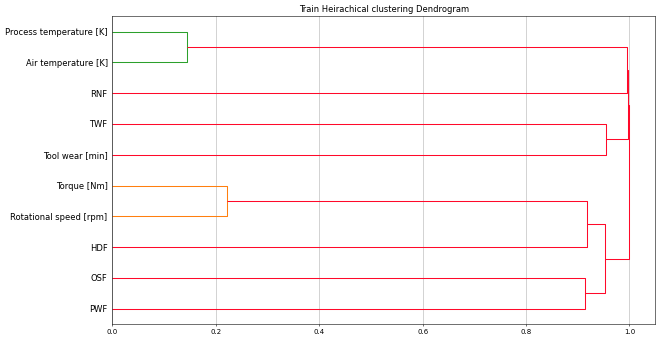

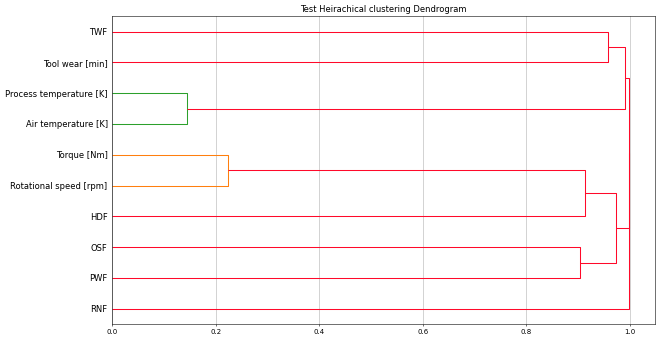

In [61]:
def plot_dendrogram(data, name):
    fig, ax = plt.subplots(1,1, figsize = (14,8), dpi=50)
    correlations = data.corr()
    coverted_corr = 1 - np.abs(correlations)
    Z = linkage(squareform(coverted_corr), 'complete')

    dn = dendrogram(Z, labels=data.columns, ax=ax, above_threshold_color= '#FF092A', orientation = 'right')
    hierarchy.set_link_color_palette(None)
    plt.grid(axis='x')
    plt.title(f'{name} Heirachical clustering Dendrogram')
    plt.show()
plot_dendrogram(df_train[num_cols + binary_cols], name ='Train')
plot_dendrogram(df_test[num_cols + binary_cols], name ='Test')

We used Dendrogram for finding the relationships between numeric columns and binary columns based on their similarities or distances.

##Visualize Data type

Text(0.5, 1.0, 'Data types')

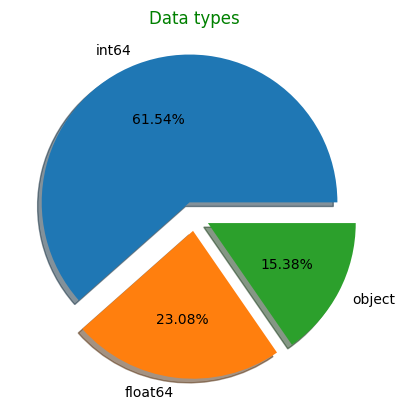

In [62]:
df_train.dtypes.value_counts().plot.pie(explode=[0.1 , 0.1, 0.1],
                                        autopct = '%1.2f%%',
                                        shadow = True)
plt.title('Data types',
          color ='Green',
          loc='Center')

##NULL in Traindata


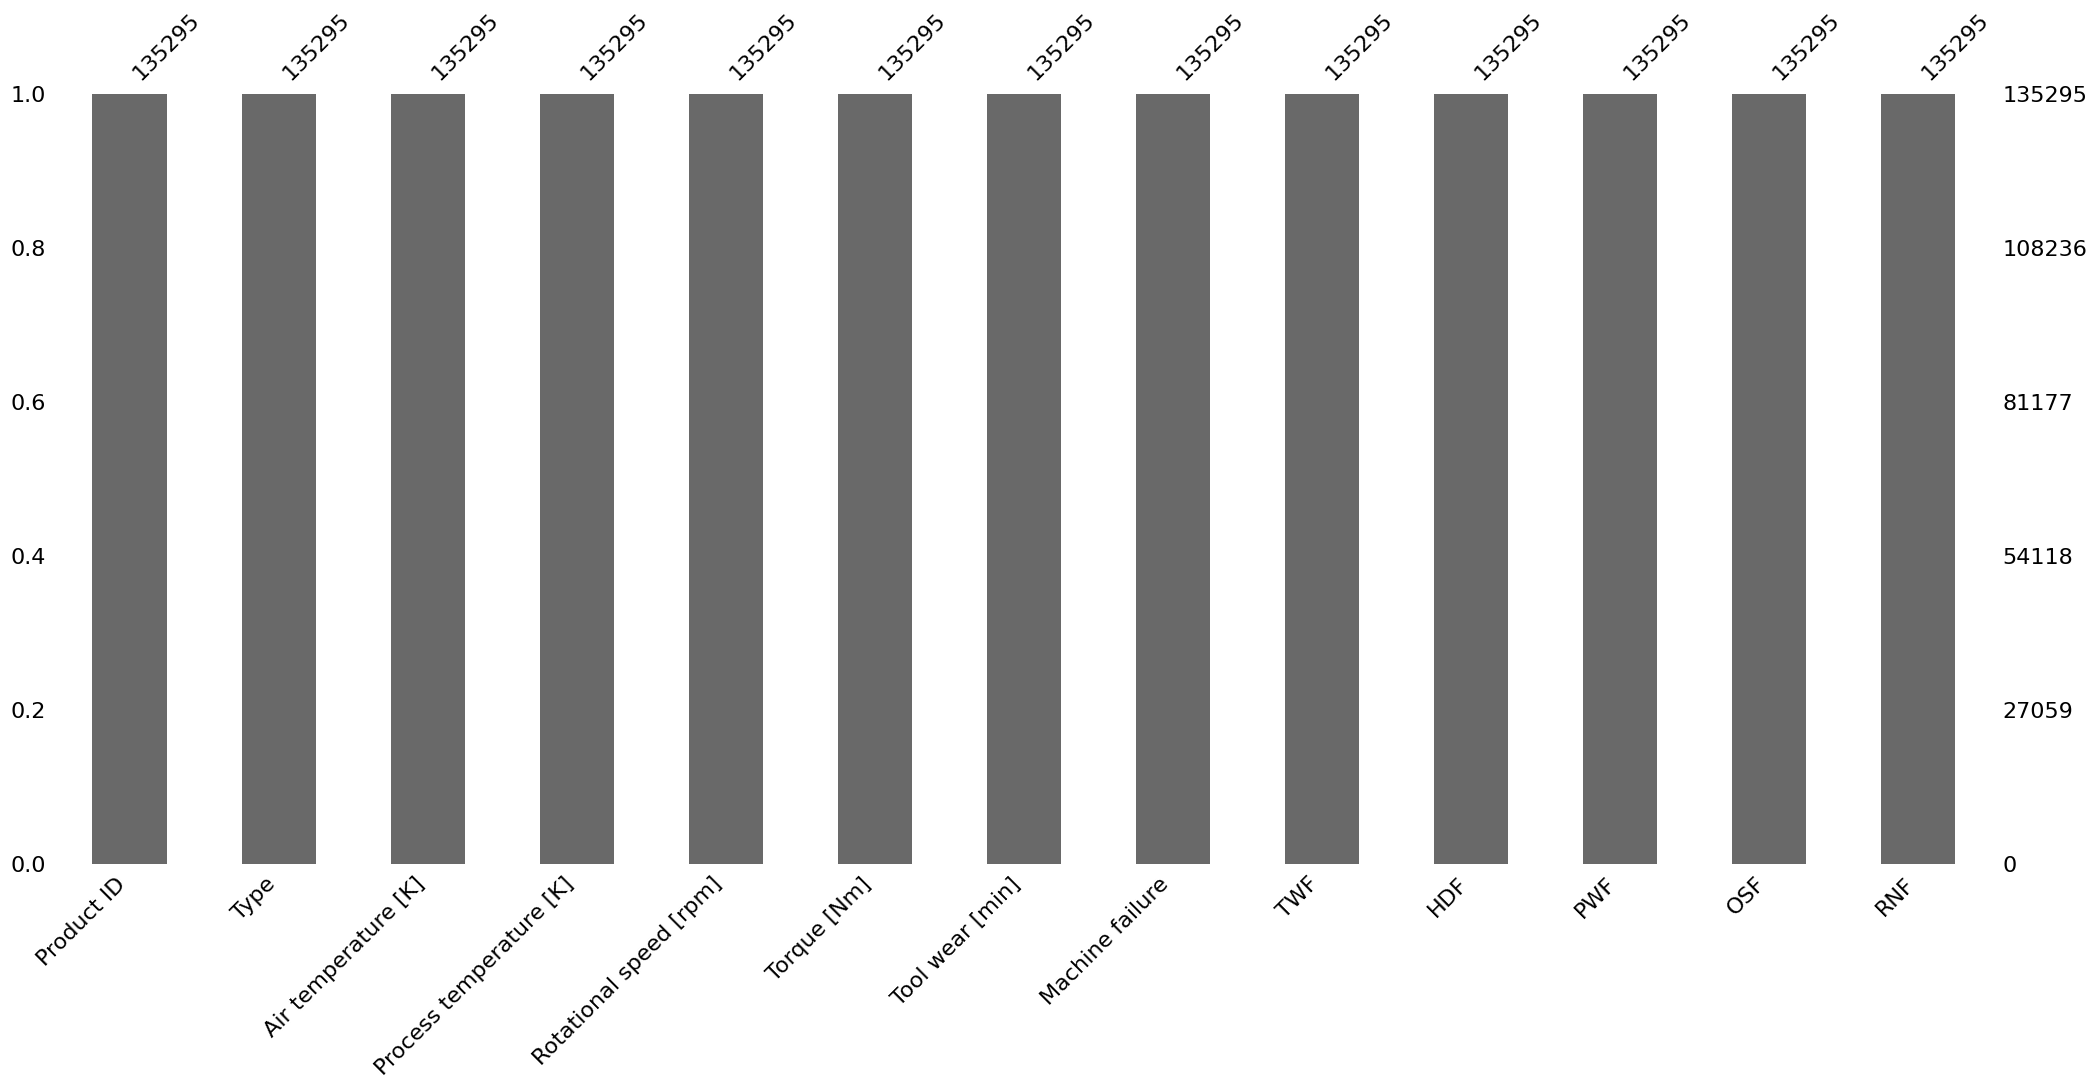

In [63]:
msno.bar(df_train)
plt.show()

##Distribution of Type machine

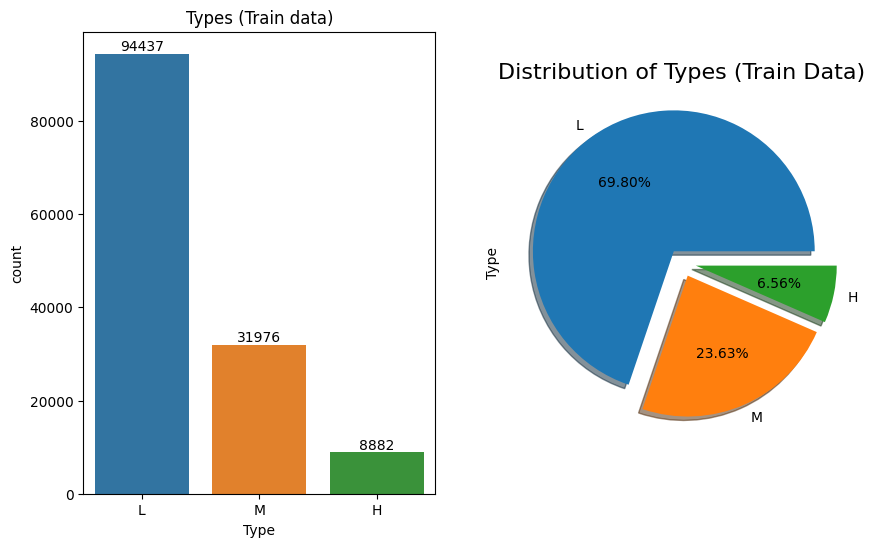

In [64]:
def plot_type_distribution(train_data):
    plt.figure(figsize = (10,6))
    ax1 = plt.subplot(1,2,1)
    ax1= sns.countplot(x='Type', data=train_data, ax= ax1)
    ax1.bar_label(ax1.containers[0])
    ax1.set_title("Types (Train data)")

    ax2 = plt.subplot(1,2,2)
    ax2 = train_data['Type'].value_counts().plot.pie(explode=[0.1, 0.1, 0.1], autopct='%1.2f%%', shadow=True, ax=ax2)
    ax2.set_title("Distribution of Types (Train Data)", fontsize=16)

    plt.show()

plot_type_distribution(df_train)

From the above count plot we can clearly see there are more light machines than the other 2
- L-> Light
- M -> Medium
- H -> Heavy

##Visualization of binary machine failure

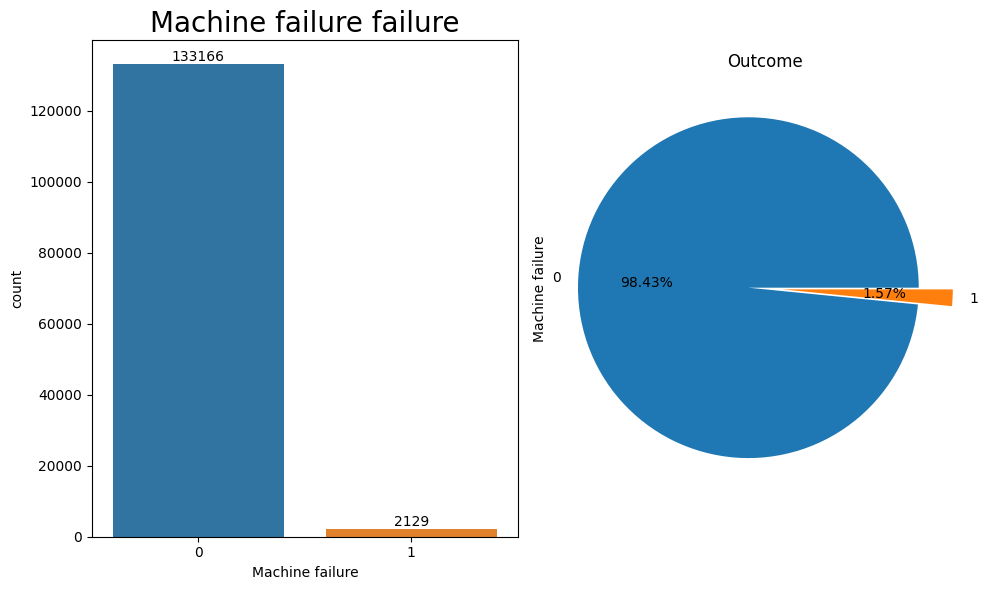

In [65]:
def plot_binary_machine_failure(dataframe, column):
    plt.figure(figsize = (10,6))

    # Countplot machine failure
    ax = plt.subplot(1,2,1)
    ax = sns.countplot(x = column, data=dataframe)
    ax.bar_label(ax.containers[0])
    plt.title(column + ' failure', fontsize = 20)

    # Pie chart for Outcome
    ax = plt.subplot(1,2,2)
    outcome_count = dataframe[column].value_counts()
    ax = outcome_count.plot.pie(explode = [0.1, 0.1], autopct='%1.2f%%')
    ax.set_title("Outcome")

    plt.tight_layout()
    plt.show()

plot_binary_machine_failure(df_train, 'Machine failure')

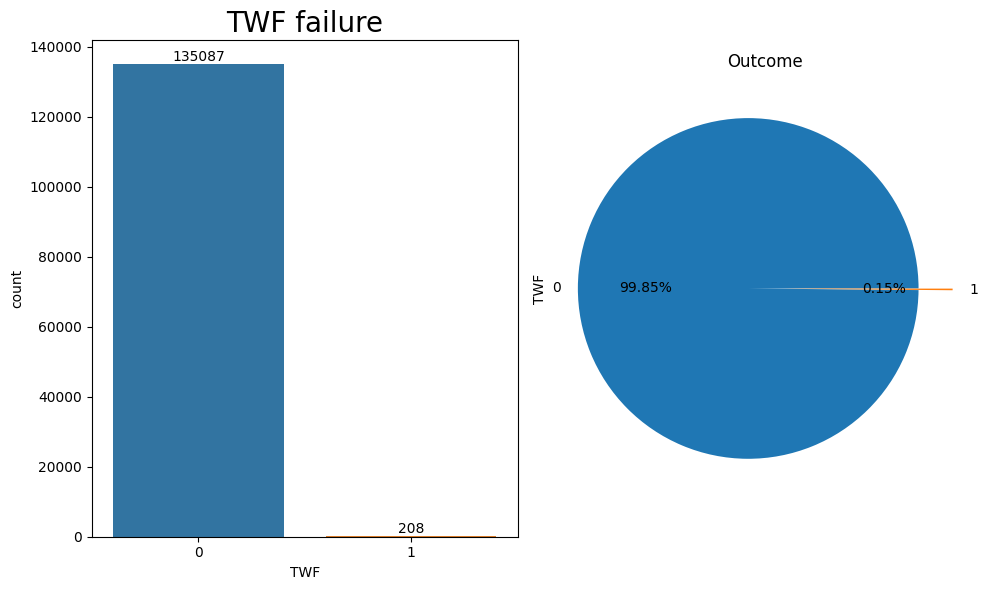

In [66]:
plot_binary_machine_failure(df_train, 'TWF')

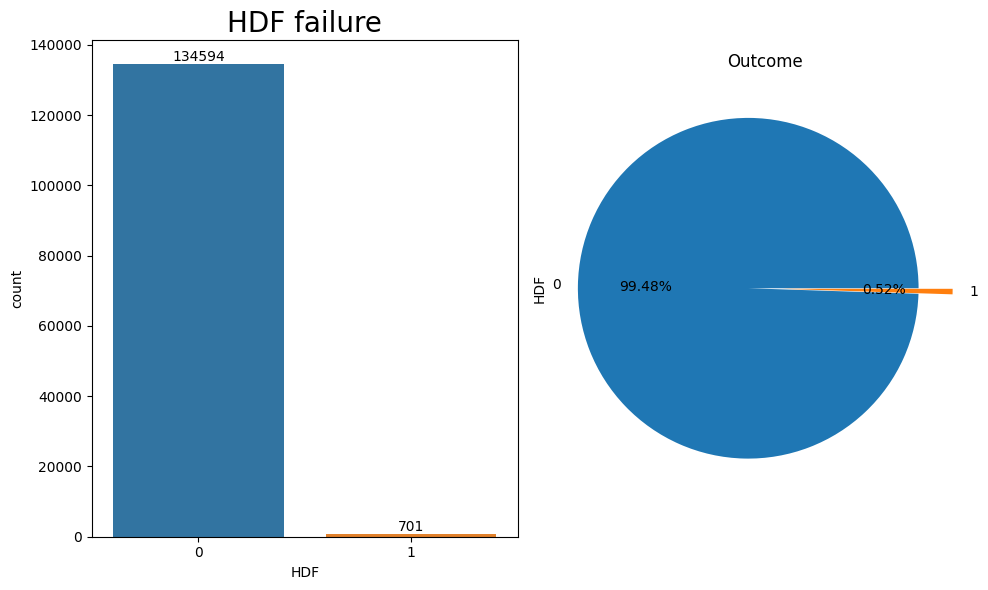

In [67]:
plot_binary_machine_failure(df_train, 'HDF')

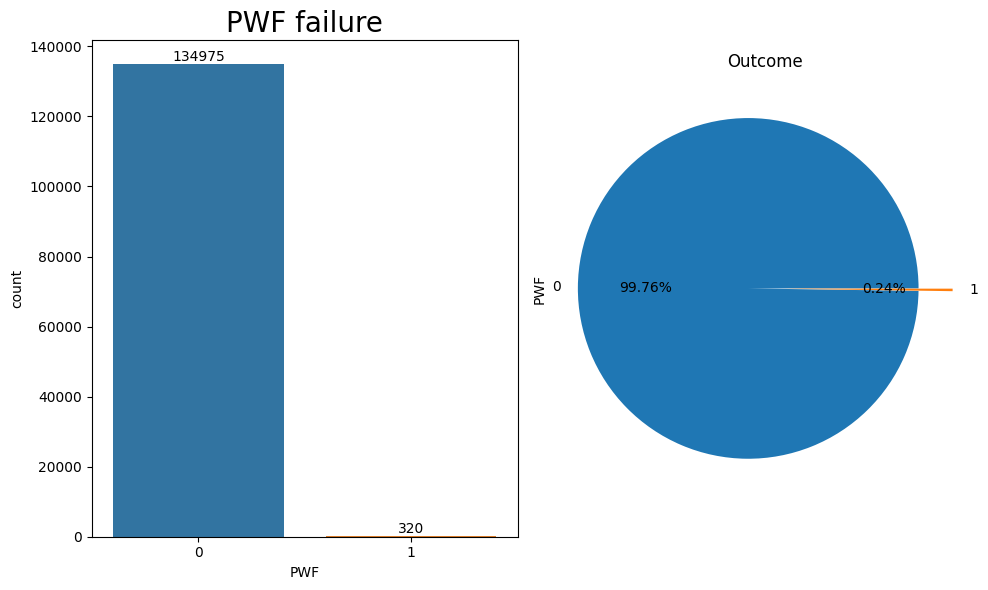

In [68]:
plot_binary_machine_failure(df_train, 'PWF')

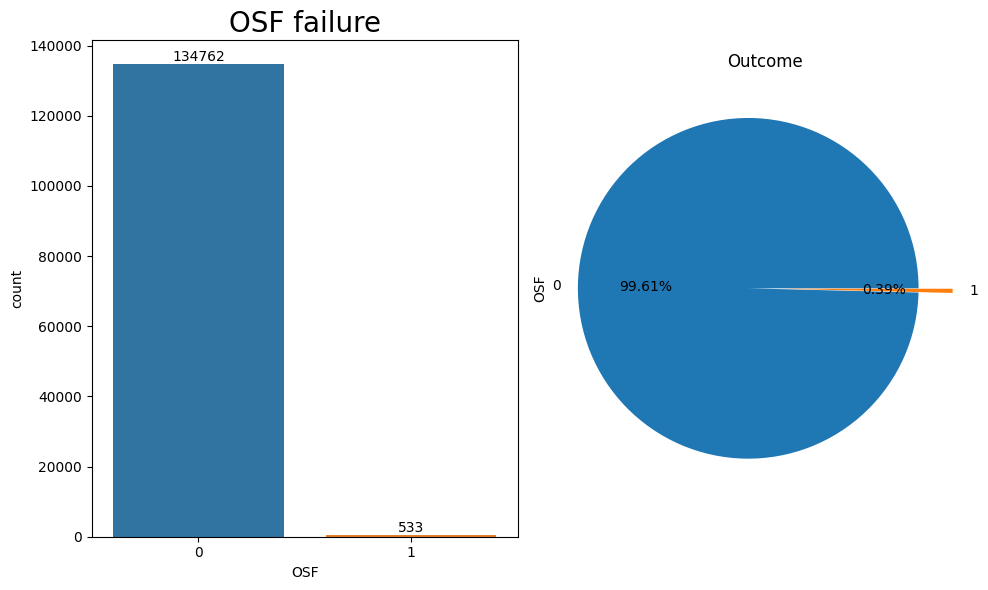

In [69]:
plot_binary_machine_failure(df_train, 'OSF')

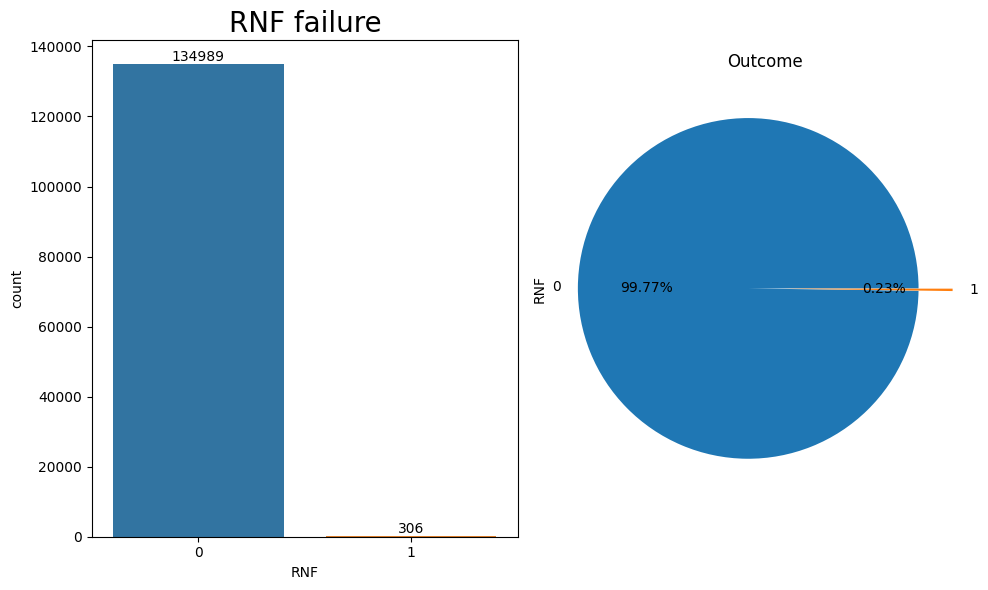

In [70]:
plot_binary_machine_failure(df_train, 'RNF')

In [71]:
# checking the count of total failures ==1 & Machine failure ==0 in Train data
TotalFt_1 = df_train[(df_train[binary_cols] == 1).any(axis=1) & (df_train[target_col] == 0)]
counts = len(TotalFt_1)
print(counts)

311


##Machine failure by type

In [72]:
failure_counts = df_train.loc[df_train['Machine failure'] == 1, 'Type'].value_counts()
failure_counts

L    1579
M     434
H     116
Name: Type, dtype: int64

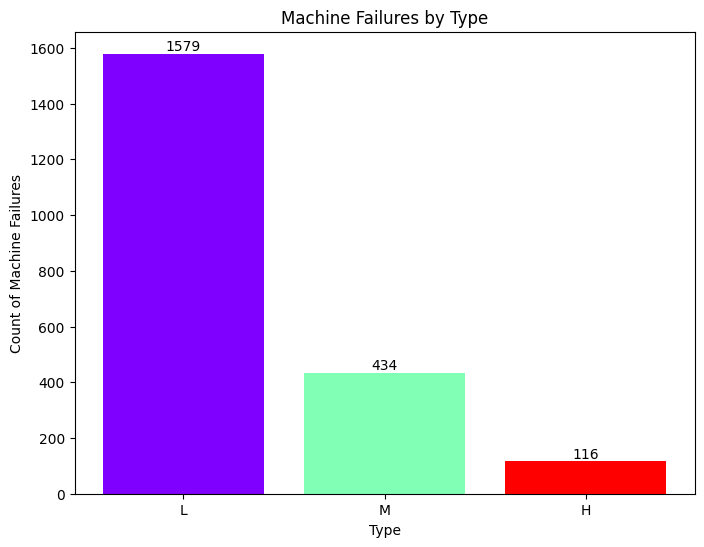

In [73]:
# Get the unique types and their counts
types = failure_counts.index
counts = failure_counts.values

# Create a colormap
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(types)))

# Plot the counts for each type
plt.figure(figsize=(8, 6))
bars = plt.bar(types, counts, color=colors)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

plt.xlabel('Type')
plt.ylabel('Count of Machine Failures')
plt.title('Machine Failures by Type')
plt.show()

##Numerical distributions

In [74]:
def plot_numerical_distributions(dataframe, columns_to_plot, num_rows, num_cols):
    # Creat the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,10))
    # Flatten axes array
    axes = axes.flatten()

    # Distribution plot for feature with respect to 'Type'
    for i, column in enumerate(columns_to_plot):
        sns.histplot(data=dataframe, x=column, hue='Type', kde=True, multiple ='stack', ax =axes[i])
        axes[i].set_title(f"Distibution Plot: {column}")
        axes[i].set_xlabel(column)
        axes[i].legend(title = 'Type', labels = ['L', 'M', 'H'])

    # Remove unused subplot
    if len(columns_to_plot) < num_rows * num_cols:
        for j in range(len(columns_to_plot), num_rows* num_cols):
            fig.delaxes(axes[j])

    # Adjust the spacing between subplots
    fig.suptitle("Distibution Plots for Numberical Features", fontsize =24, fontweight='bold', y=1.10)
    fig.tight_layout()

    plt.show()

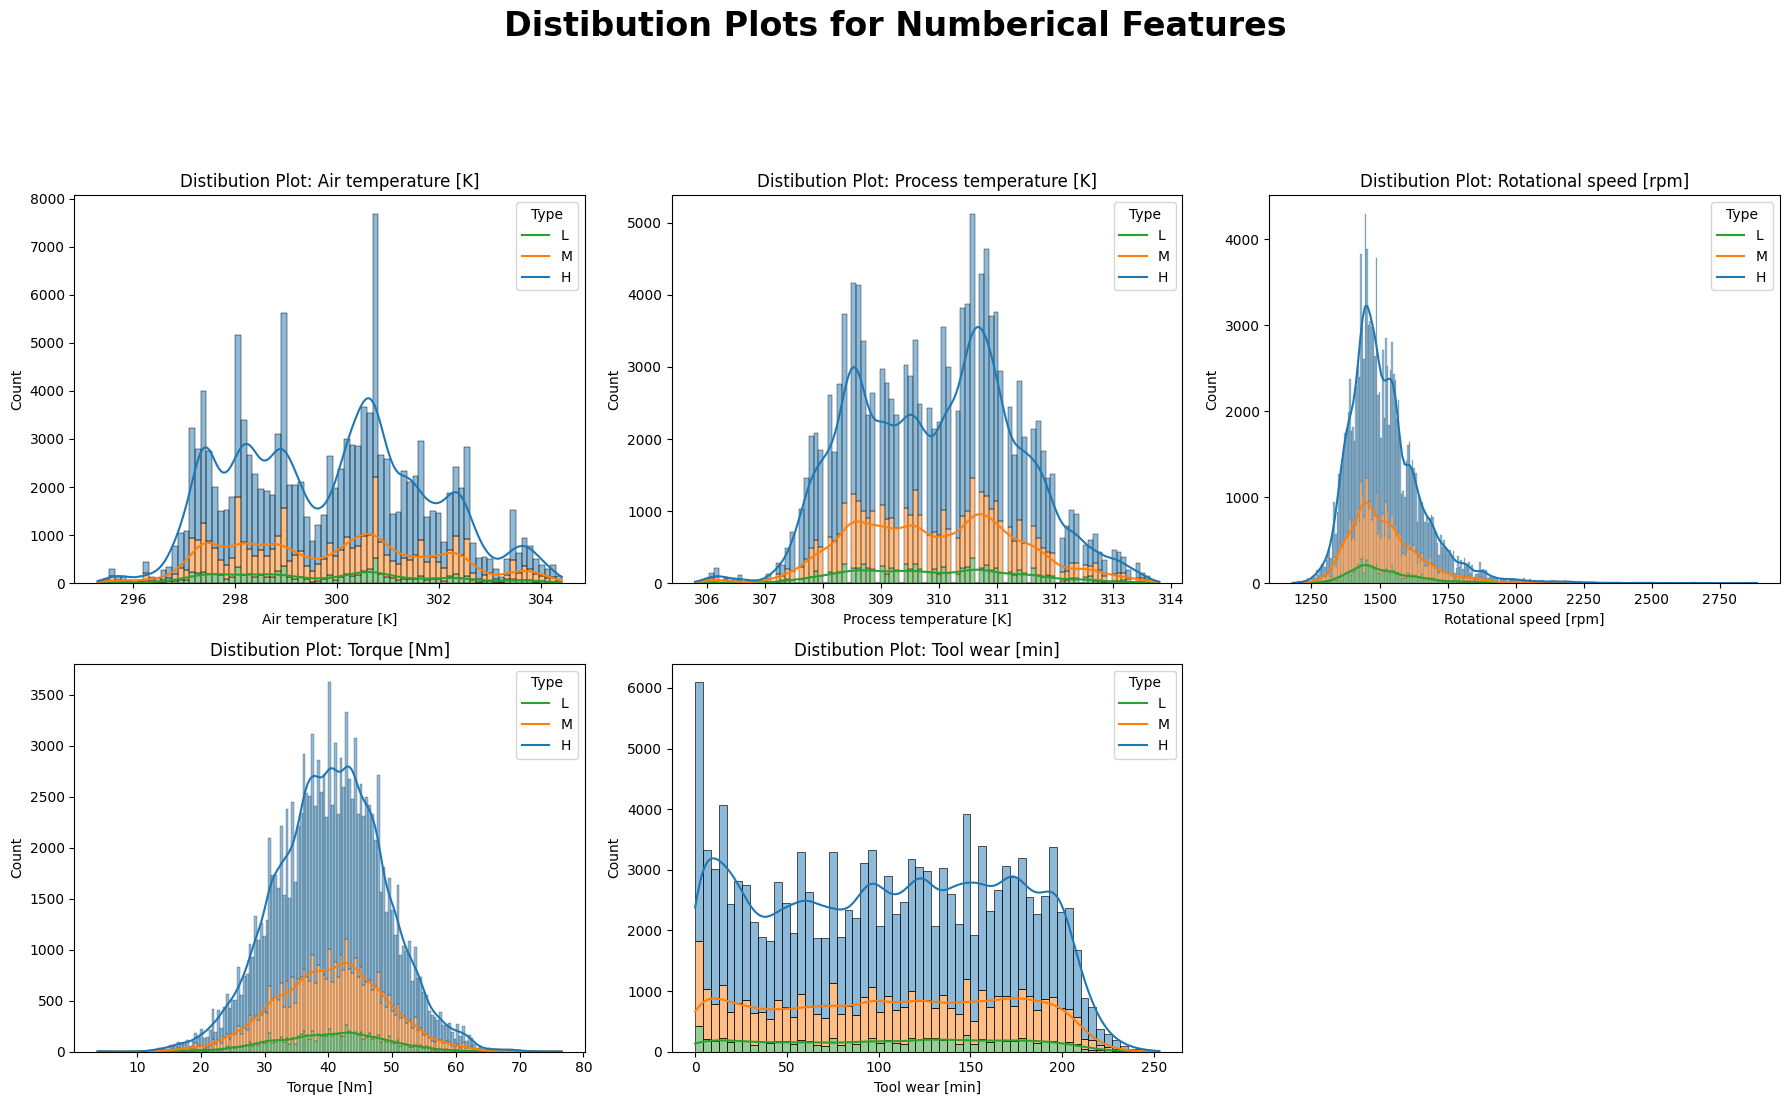

In [75]:
columns_to_plot = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
num_rows = 2
num_cols = 3

plot_numerical_distributions(df_train, columns_to_plot, num_rows, num_cols)

## Handling Data: Tool wear

In [76]:
# Function to check the count of tool wear has a value 0 to Machine failure
def count_tool_wear_zeros(data):
    toolwear_df_0 = data[(data['Machine failure'] == 0) & (data['Tool wear [min]'] == 0)]
    count_0 = len(toolwear_df_0)
    toolwear_df_1 = data[(data['Machine failure'] == 1) & (data['Tool wear [min]'] == 0)]
    count_1 = len(toolwear_df_1)

    print("Number of 0 in Tool wear with Machine failure = 0 : ", count_0)
    print("Number of 0 in Tool wear with Machine failure = 1 : ", count_1)

In [77]:
count_tool_wear_zeros(df_train)

Number of 0 in Tool wear with Machine failure = 0 :  3723
Number of 0 in Tool wear with Machine failure = 1 :  40


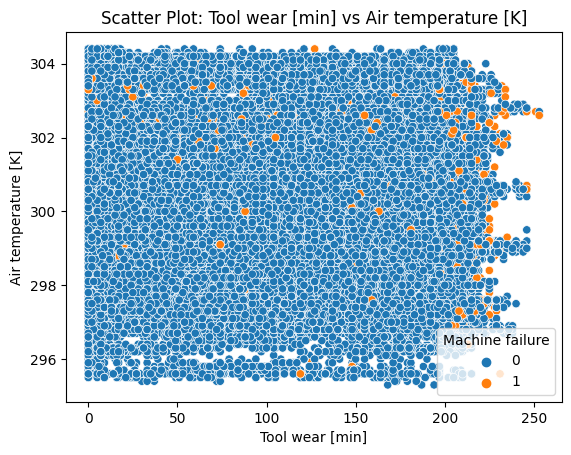

In [78]:
# Scatter plot with hue
sns.scatterplot(data=df_train, x='Tool wear [min]', y='Air temperature [K]', hue ='Machine failure')
plt.xlabel('Tool wear [min]')
plt.ylabel('Air temperature [K]')
plt.title('Scatter Plot: Tool wear [min] vs Air temperature [K]')
plt.show()

In [79]:
# Using Knn imputer to change the Tool wear Zero(0) Values based on Machine failure == 1
df_train.loc[df_train['Machine failure'] == 1, "Tool wear [min]"] = df_train.loc[df_train['Machine failure'] == 1, "Tool wear [min]"].replace(0,np.nan)
mask_1 = df_train['Machine failure'] ==1

#Perform KNN imputation on tool wear column for the selected rows
imputer = KNNImputer(n_neighbors=5 )
df_train.loc[mask_1, 'Tool wear [min]'] = imputer.fit_transform(df_train.loc[mask_1, 'Tool wear [min]'].values.reshape(-1,1))

df_train.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140.0,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200.0,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25.0,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197.0,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34.0,0,0,0,0,0,0


Analysis:
- If the machine failure happens then the tool wear value not be 0 but when it comes to non machine failure the tool wear may be 0 so i will try to impute those values with KNN

##Handling Data: TWF,HDF,PWF,OSF,RNF

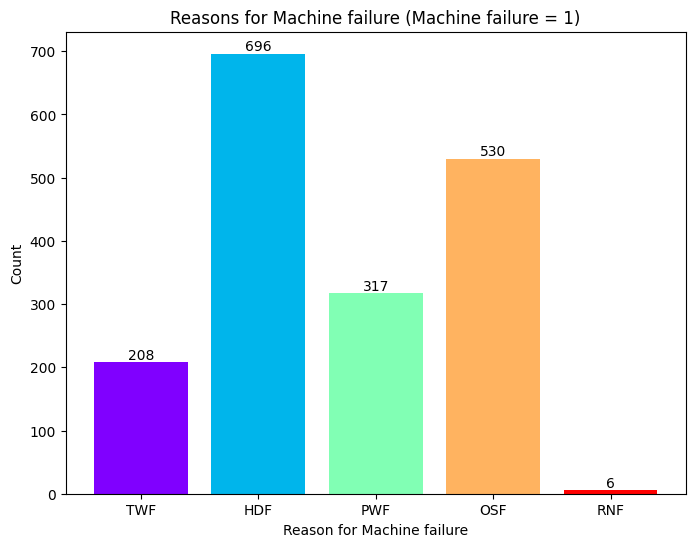

In [80]:
reason_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Filter data for machine failure
failures_data = df_train[df_train['Machine failure']==1]

# Count the occurrences of each reason for machine failure
reason_counts = failures_data[reason_columns].sum()

# Create a color map
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0,1, len(reason_columns)))

# Plot the reason counts
plt.figure(figsize = (8,6))
bars =plt.bar(reason_columns, reason_counts, color=colors)

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x()+ bar.get_width()/2, height, str(int(height)), ha ='center', va='bottom')

plt.xlabel('Reason for Machine failure')
plt.ylabel('Count')
plt.title('Reasons for Machine failure (Machine failure = 1)')
plt.show()

In [81]:
# df_1 where machine failure = 1
df_1 = df_train[df_train['Machine failure'] == 1]
df_1

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
130,L52498,L,303.9,312.8,1345,56.5,21.0,1,0,0,0,0,0
164,L51721,L,302.5,310.4,1307,54.8,174.0,1,0,1,0,0,0
228,M17895,M,300.7,309.7,1878,27.9,20.0,1,0,0,0,0,0
236,L55926,L,297.3,308.6,1258,61.8,144.0,1,0,0,0,1,0
247,L51801,L,303.0,311.3,1341,51.0,174.0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135902,L52669,L,302.6,312.1,1638,35.0,215.0,1,1,0,0,0,0
135917,L56200,L,297.3,308.2,1553,33.5,208.0,1,1,0,0,0,0
135957,L55410,L,299.1,310.6,1353,49.7,74.0,1,0,0,0,0,0


In [82]:
features_index = list(df_1.index)
columns = list(df_1.iloc[:,-5:].columns)
df_train.loc[features_index,columns] = df_1.loc[features_index,columns]

In [83]:
# Where machine failure = 1 but all reasons = 0 (503/2139)
failures_df_1 = df_1[(df_1['TWF']==0) & (df_1['HDF']==0) & (df_1['PWF']==0) & (df_1['OSF']==0) & (df_1['RNF']==0) ]

# Replace all 0 which NaN
for x in failures_df_1.iloc[:,-5:].columns:
    failures_df_1.replace(0,np.nan, inplace=True)

In [84]:
features_index = list(failures_df_1.index)
columns = list(failures_df_1.iloc[:,-5:].columns)
df_1.loc[features_index,columns] = failures_df_1.loc[features_index,columns]

In [85]:
imputer = KNNImputer(n_neighbors =10)

df_imputer = imputer.fit_transform(df_1.iloc[:,2:])

# Conver the imputer array back to dataframe
df_imputer = pd.DataFrame(df_imputer, columns = df_1.iloc[:,2:].columns)
df_imputer

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,303.9,312.8,1345.0,56.5,21.0,1.0,0.0,0.9,0.1,0.0,0.0
1,302.5,310.4,1307.0,54.8,174.0,1.0,0.0,1.0,0.0,0.0,0.0
2,300.7,309.7,1878.0,27.9,20.0,1.0,0.2,0.4,0.3,0.1,0.0
3,297.3,308.6,1258.0,61.8,144.0,1.0,0.0,0.0,0.0,1.0,0.0
4,303.0,311.3,1341.0,51.0,174.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2124,302.6,312.1,1638.0,35.0,215.0,1.0,1.0,0.0,0.0,0.0,0.0
2125,297.3,308.2,1553.0,33.5,208.0,1.0,1.0,0.0,0.0,0.0,0.0
2126,299.1,310.6,1353.0,49.7,74.0,1.0,0.0,1.0,0.0,0.0,0.0
2127,302.4,312.0,1286.0,62.3,162.0,1.0,0.0,0.0,1.0,0.0,0.0


In [86]:
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Apply the condition and replace values in the failure columns
df_imputer[failure_columns] = df_imputer[failure_columns].applymap(lambda x: 0  if x<0.1 else 1)
df_imputer

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,303.9,312.8,1345.0,56.5,21.0,1.0,0,1,1,0,0
1,302.5,310.4,1307.0,54.8,174.0,1.0,0,1,0,0,0
2,300.7,309.7,1878.0,27.9,20.0,1.0,1,1,1,1,0
3,297.3,308.6,1258.0,61.8,144.0,1.0,0,0,0,1,0
4,303.0,311.3,1341.0,51.0,174.0,1.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2124,302.6,312.1,1638.0,35.0,215.0,1.0,1,0,0,0,0
2125,297.3,308.2,1553.0,33.5,208.0,1.0,1,0,0,0,0
2126,299.1,310.6,1353.0,49.7,74.0,1.0,0,1,0,0,0
2127,302.4,312.0,1286.0,62.3,162.0,1.0,0,0,1,0,0


In [87]:
features_index = list(df_imputer.index)
columns = list(df_imputer.iloc[:,-5:].columns)
df_train.loc[features_index,columns] = df_imputer.loc[features_index,columns]

In [88]:
df_train

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140.0,0,0,1,1,0,0
1,M20343,M,302.6,312.1,1759,29.1,200.0,0,0,1,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25.0,0,1,1,1,1,0
3,L53355,L,301.0,310.9,1524,44.3,197.0,0,0,0,0,1,0
4,M24050,M,298.0,309.0,1641,35.4,34.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,M22284,M,300.1,311.4,1530,37.5,210.0,0,0,0,0,0,0
136425,H38017,H,297.5,308.5,1447,49.1,2.0,0,0,0,0,0,0
136426,L54690,L,300.5,311.8,1524,38.5,214.0,0,0,0,0,0,0


Analysis:
- The merged dataset contains a total of 2797 instances of machine failures. These failures are categorized into types such as TWF, HDF, PWF, OSF, and RNF. Normally, when a machine failure occurs, the corresponding type will have a value of 1. However, it is puzzling that out of the 2797 machine failures, 512 instances do not have any type specified (i.e., they have a value of 0). To address this issue and make the data more meaningful, I imputed these 0 values using a KNN imputer.

## Correlation matrix

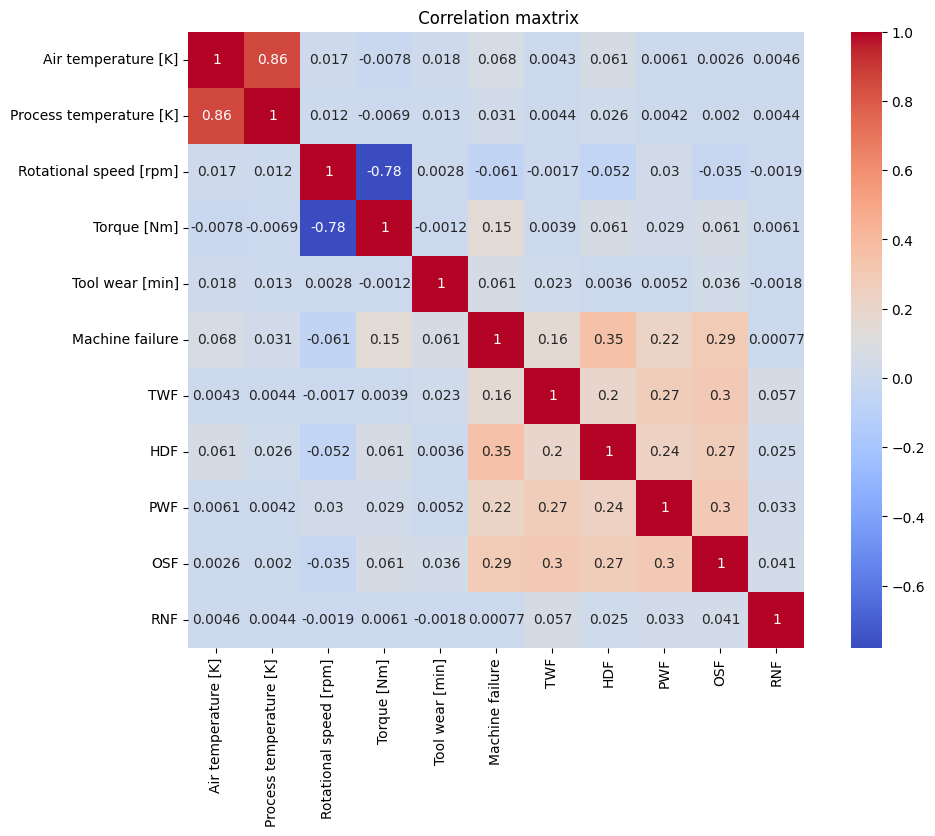

In [89]:
columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
           'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
corr_matrix = df_train[columns].corr()

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot =True, cmap ='coolwarm', square =True)
plt.title(' Correlation maxtrix')
plt.show()

Analysis: Correlation Matrix
- Air temperature and process temperature have a strong positive correlation of 0.856. This indicates that as the air temperature increases, the process temperature tends to increase as well.
- Rotational speed and torque exhibit a significant negative correlation of -0.779. This suggests that higher rotational speed is associated with lower torque values.
- Machine failure and HDF (Hydraulic component failures) have a relatively high correlation of 0.355. This indicates that there is some relationship between machine failures and hydraulic component failures.

#  Outliers Detection

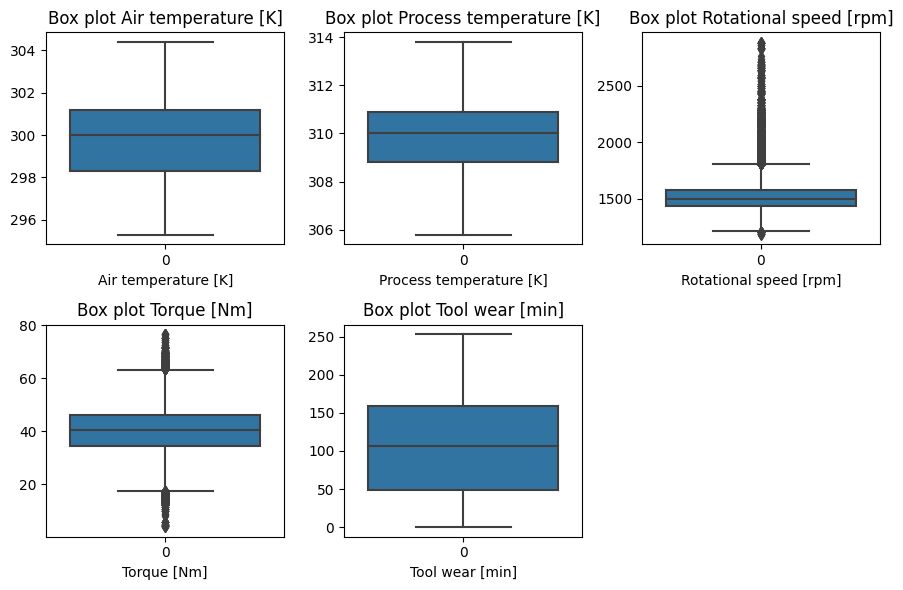

In [90]:
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize = (9,6))
for i, column in enumerate(numerical_columns):
    plt.subplot(2,3, i+1)
    sns.boxplot(data=df_train[column])
    plt.title(f'Box plot {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

#Feature Engineering

In [91]:
# Create new features by comparing other ones
def New_Features(df):
    df['TemperatureDifference'] = df['Process temperature [K]'] - df['Air temperature [K]']

    df['TemperatureRatio'] = df['Process temperature [K]'] / df['Air temperature [K]']

    df['TemperatureVariability'] = df[['Air temperature [K]', 'Process temperature [K]']].std(axis=1)

    df['TemperatureChangeRate'] = df['TemperatureDifference'] / df['Tool wear [min]']

    df['TemperatureChangeRate'] = np.where(df['TemperatureChangeRate']== float('inf'),1, df['TemperatureChangeRate'])

    df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    df['ToolWearRate'] = df['Tool wear [min]'] / df['Tool wear [min]'].max()

    df['TF'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

    return df

Why we created new features :
- The function "New_Features" introduces new derived features to the dataset, such as 'TemperatureDifference' and 'TemperatureRatio', which capture the temperature relationship between the process and air temperature. This additional information may provide valuable insights for the machine learning model to make more accurate predictions.

- The function also calculates the 'Power' feature by multiplying the 'Torque [Nm]' and 'Rotational speed [rpm]', which can potentially capture the combined effect of these two variables on the machine's performance. By including this feature, the model may benefit from a more comprehensive representation of the relationship between torque, rotational speed, and power consumption.

In [92]:
df_train = New_Features(df_train)
df_test = New_Features(df_test)

In [93]:
from sklearn.preprocessing import RobustScaler

def apply_robust_scaler(data, columns):
    scaler = RobustScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return data

scaler_columns =["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]","TWF", "HDF", "PWF", "OSF", "RNF", "Power","TemperatureDifference", "TemperatureVariability", "TemperatureRatio", "ToolWearRate", "TemperatureChangeRate", "TF"]

train_df = apply_robust_scaler(df_train, scaler_columns)
test_df = apply_robust_scaler(df_test, scaler_columns)

Why we use Robust Scaler :
>RobustScaler is applied to standardize numerical features by removing the median and scaling the data according to the interquartile range (IQR). This scaling technique is robust to outliers and is particularly useful when the data contains extreme values or non-normal distributions. It helps to bring the features to a similar scale, making them more comparable and improving the performance of certain machine learning algorithms.

In [94]:
# Remove special characters
def remove_special_character(column_name):
    pattern = r'[^A-Za-z0-9_]+'
    return re.sub(pattern, '', column_name)

train = train_df.rename(columns=lambda x: remove_special_character(x))
test = test_df.rename(columns=lambda x: remove_special_character(x))

In [100]:
feature_names = train.drop('Machinefailure', axis = 1).columns.tolist()

#CatBoost
CatBoost is a gradient boosting algorithm specifically designed to handle categorical variables in machine learning tasks. It employs an innovative approach called ordered boosting, which incorporates the natural ordering of categorical features to improve accuracy. CatBoost automatically handles missing values and incorporates advanced techniques like target encoding and feature combinations. It provides fast and scalable training, and its powerful handling of categorical data makes it a popular choice for classification tasks.

In [97]:
train.columns

Index(['ProductID', 'Type', 'AirtemperatureK', 'ProcesstemperatureK',
       'Rotationalspeedrpm', 'TorqueNm', 'Toolwearmin', 'Machinefailure',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'TemperatureDifference',
       'TemperatureRatio', 'TemperatureVariability', 'TemperatureChangeRate',
       'Power', 'ToolWearRate', 'TF'],
      dtype='object')

In [102]:
%%time
# Split the data into features (X) and target variable (y)
X = train.drop(columns=['Machinefailure'], axis=1)
y = train['Machinefailure']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13)

#Create the Pool objects with categorical features
pool_train = Pool(X_train, y_train, feature_names=feature_names, cat_features=['ProductID', 'Type'])
pool_valid = Pool(X_valid, y_valid, feature_names=feature_names, cat_features=['ProductID', 'Type'])

# Set the best parameters obtained from Optuna
cb_parames = {
    'n_estimators': 3261,
    'max_depth': 5,
    'learning_rate': 0.025184406348245668,
    'max_bin': 306,
    'random_strength': 0.23,
    'grow_policy': 'Lossguide',
    'bootstrap_type': 'Bayesian',
    'objective':'Logloss',
    "loss_function": "AUC",
    'eval_metric': "AUC",
    'l2_leaf_reg':  0.06609180403841047,
    'min_child_samples': 140,
    'random_state': 13,
    'silent': True,
    'task_type': 'GPU',
}

# Build the model with the best parameters
model = CatBoostClassifier(**cb_parames)

# Fit the model to the training data
model.fit(pool_train)

# Make predictions on the validation data
y_pred = model.predict(pool_valid)

Default metric period is 5 because AUC is/are not implemented for GPU


CPU times: user 1min 13s, sys: 36.6 s, total: 1min 50s
Wall time: 1min 11s


Fine tuning parameters Values:
- Optuna is a hyperparameter optimization framework in Python. It provides a flexible and efficient framework for automating the parameter optimization process and improving the performance of machine learning models.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26625
           1       0.87      0.73      0.80       434

    accuracy                           0.99     27059
   macro avg       0.93      0.86      0.90     27059
weighted avg       0.99      0.99      0.99     27059



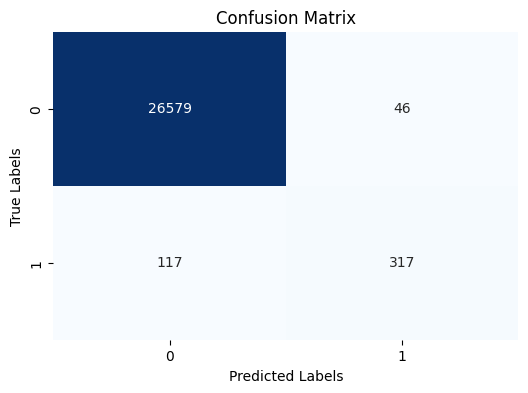

In [103]:
# Calculate and print the classification report
print("Classification Report:")
print(classification_report(y_valid, y_pred))

# Calculate and print the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
# print("Confusion Matrix:")
# print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate the probabilities for each class
y_prob = model.predict_proba(pool_valid)[:, 1]

Area under ROC curve: 0.9726806429977715


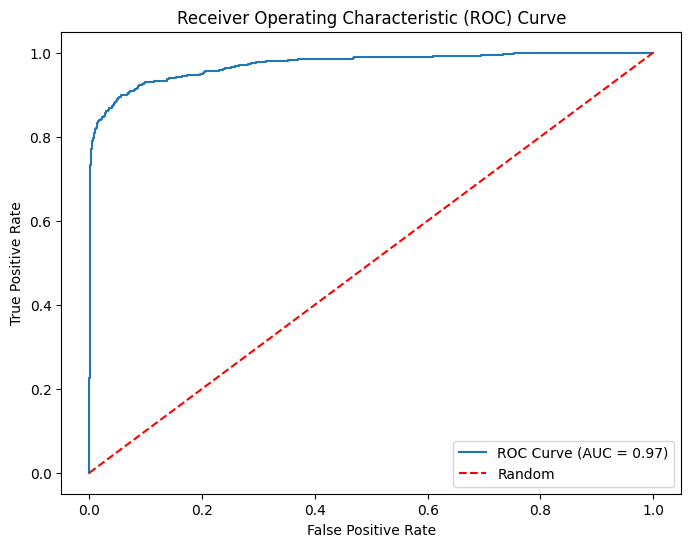

In [104]:
# Calculate the area under the ROC curve
roc_auc = roc_auc_score(y_valid, y_prob)
print("Area under ROC curve:", roc_auc)

# Compute the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_valid, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

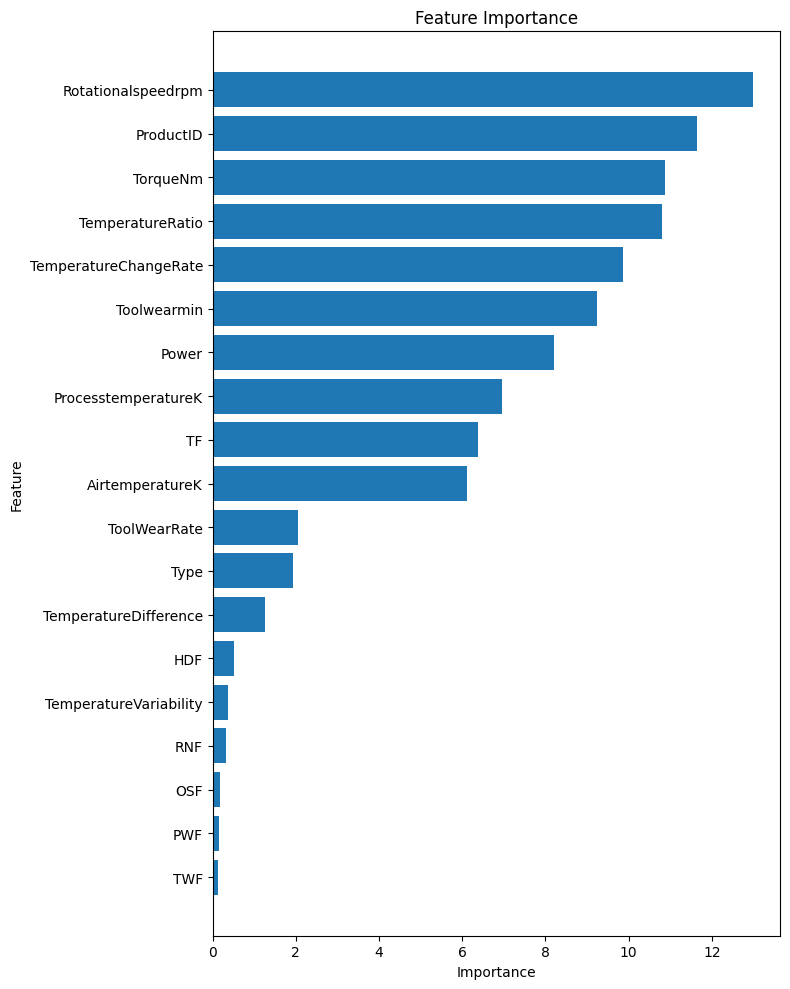

In [105]:
# Get the feature importance
feature_importance = model.get_feature_importance(pool_train)

# Create a dataframe with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the dataframe by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)  # Sort in ascending order

# Create a vertical bar plot of feature importance
plt.figure(figsize=(8, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [106]:
df_results = pd.DataFrame({'Actual': y_valid, 'Predicted': y_pred})
# Print the dataframe
df_results.T

id,87038,134589,1772,121364,113228,128501,107964,11470,53360,119310,...,76386,516,117183,39492,87232,86032,131009,51131,21917,130787
Actual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Predicted,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
%%time
# predict on the test data
y_predict_catboost = model.predict(test)

CPU times: user 7.53 s, sys: 0 ns, total: 7.53 s
Wall time: 5.37 s


In [108]:
# Make a submission
df_submission['Machine failure']=y_predict_catboost
df_submission

,Machine failure
id,
136429,0
136430,0
136431,0
136432,0
136433,0
...,...
227378,0
227379,0
227380,0


In [109]:
# save it into csv
df_submission.to_csv('catboost.csv')

In [110]:
from google.colab import files
files.download('catboost.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>